# **Navires 2023 libre**

## Auteurs
### Majeure IMAGE

- David CHEMALY
    - login: david.chemaly
    

- Raphaël DUHEN
    - login: raphael.duhen

# **Projet IREN - Promotion 2024**

---

## Import des données

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
input_path = '/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data'

In [4]:
!tar xzf /kaggle/input/navires-2023-libre/ships.tgz

tar (child): /kaggle/input/navires-2023-libre/ships.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [5]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
!ls /kaggle/working

__notebook__.ipynb


## Paramètres

In [7]:
img_height = 16
img_width = 24
batch_size = 32
validation_split = 0.2

## Lecture des images

Le code utilise la classe ImageDataGenerator de Keras pour générer des lots d'images augmentées à partir d'un répertoire contenant des données d'images pour la classification de bateaux. Voici un résumé de ce que le code fait :

Il crée une instance de ImageDataGenerator avec quelques options de transformation d'images :

- **horizontal_flip=True** : permet de réaliser des retournements horizontaux aléatoires des images pendant l'augmentation des données, ce qui peut aider à améliorer la robustesse du modèle.
- **rescale=1./255** : réduit les valeurs de pixels des images à l'intervalle [0, 1] en les divisant par 255.
- **validation_split=validation_split** : spécifie la proportion des données à utiliser pour la validation.

Ensuite, le générateur de données d'entraînement (training_gen) est créé en utilisant la méthode flow_from_directory :

- **input_path** : le chemin du répertoire contenant les données d'images pour l'entraînement et la validation.
- **target_size=(img_height, img_width)** : spécifie la taille souhaitée pour les images.
- **batch_size=batch_size** : définit la taille des mini-lots d'images à générer.
- **seed=SEED** : fixe la graine aléatoire pour la reproductibilité des résultats.
- **subset='training'** : indique que ce générateur est utilisé pour les données d'entraînement.
- **class_mode='categorical'** : utilise l'encodage catégoriel des étiquettes de classe.
- **color_mode='rgb'** : spécifie le mode de couleur des images en RGB.
- **shuffle=True** : mélange les images à chaque époque d'entraînement.
- **interpolation="bicubic"** : utilise l'interpolation bicubique pour redimensionner les images. L'interpolation bicubique est une méthode courante pour redimensionner les images en préservant les détails et en atténuant les artefacts.

De même, le générateur de données de validation (validation_gen) est créé en utilisant la méthode flow_from_directory. Les paramètres sont similaires à training_gen, à l'exception de subset='validation' et shuffle=False (pas de mélange des images de validation).

L'utilisation de l'interpolation bicubique pour le redimensionnement des images peut être avantageuse car elle fournit une meilleure qualité d'interpolation par rapport à d'autres méthodes plus simples, telles que l'interpolation bilinéaire. Cela peut aider à préserver les détails et les contours des bateaux dans les images redimensionnées, ce qui peut être important pour la tâche de classification.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255,
    validation_split=validation_split
)

training_gen = datagen.flow_from_directory(
    input_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=SEED,
    subset='training',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    interpolation="bicubic"
)

validation_gen = datagen.flow_from_directory(
    input_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=SEED,
    subset='validation',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    interpolation="bicubic"
)

Found 28417 images belonging to 10 classes.
Found 7098 images belonging to 10 classes.


## Présentation des données

Ce code définit une fonction appelée generator_plot qui permet de visualiser les images générées par un générateur de données. La fonction affiche les images en utilisant la bibliothèque Matplotlib, avec les étiquettes correspondantes à chaque image. Les informations sur la taille du lot, la taille des images et le nombre de canaux sont également affichées. Cette fonction est utile pour vérifier et inspecter les données générées par le générateur avant de les utiliser pour l'entraînement ou l'évaluation d'un modèle de classification.

In [9]:
def generator_plot(gen):
    labels = gen.class_indices
    batch_size = gen.batch_size
    
    plt.figure(figsize=(16, 14))
    image, lbs = gen.next()
    num_images = image.shape[0]
    image_size = image.shape[1:3]
    num_channels = image.shape[3]
    
    print(f'Batch size: {batch_size}\nImage size: {image_size[0]} x {image_size[1]}\nNumber of channels: {num_channels}')
    
    num_rows = (batch_size + 4) // 5
    num_cols = min(batch_size, 5)
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        num_class = np.argmax(lbs[i])
        class_name = list(labels.keys())[list(labels.values()).index(num_class)]
        plt.title(class_name)
        plt.imshow(image[i])
    
    plt.tight_layout()
    plt.show()
    
    gen.reset()

Batch size: 32
Image size: 16 x 24
Number of channels: 3


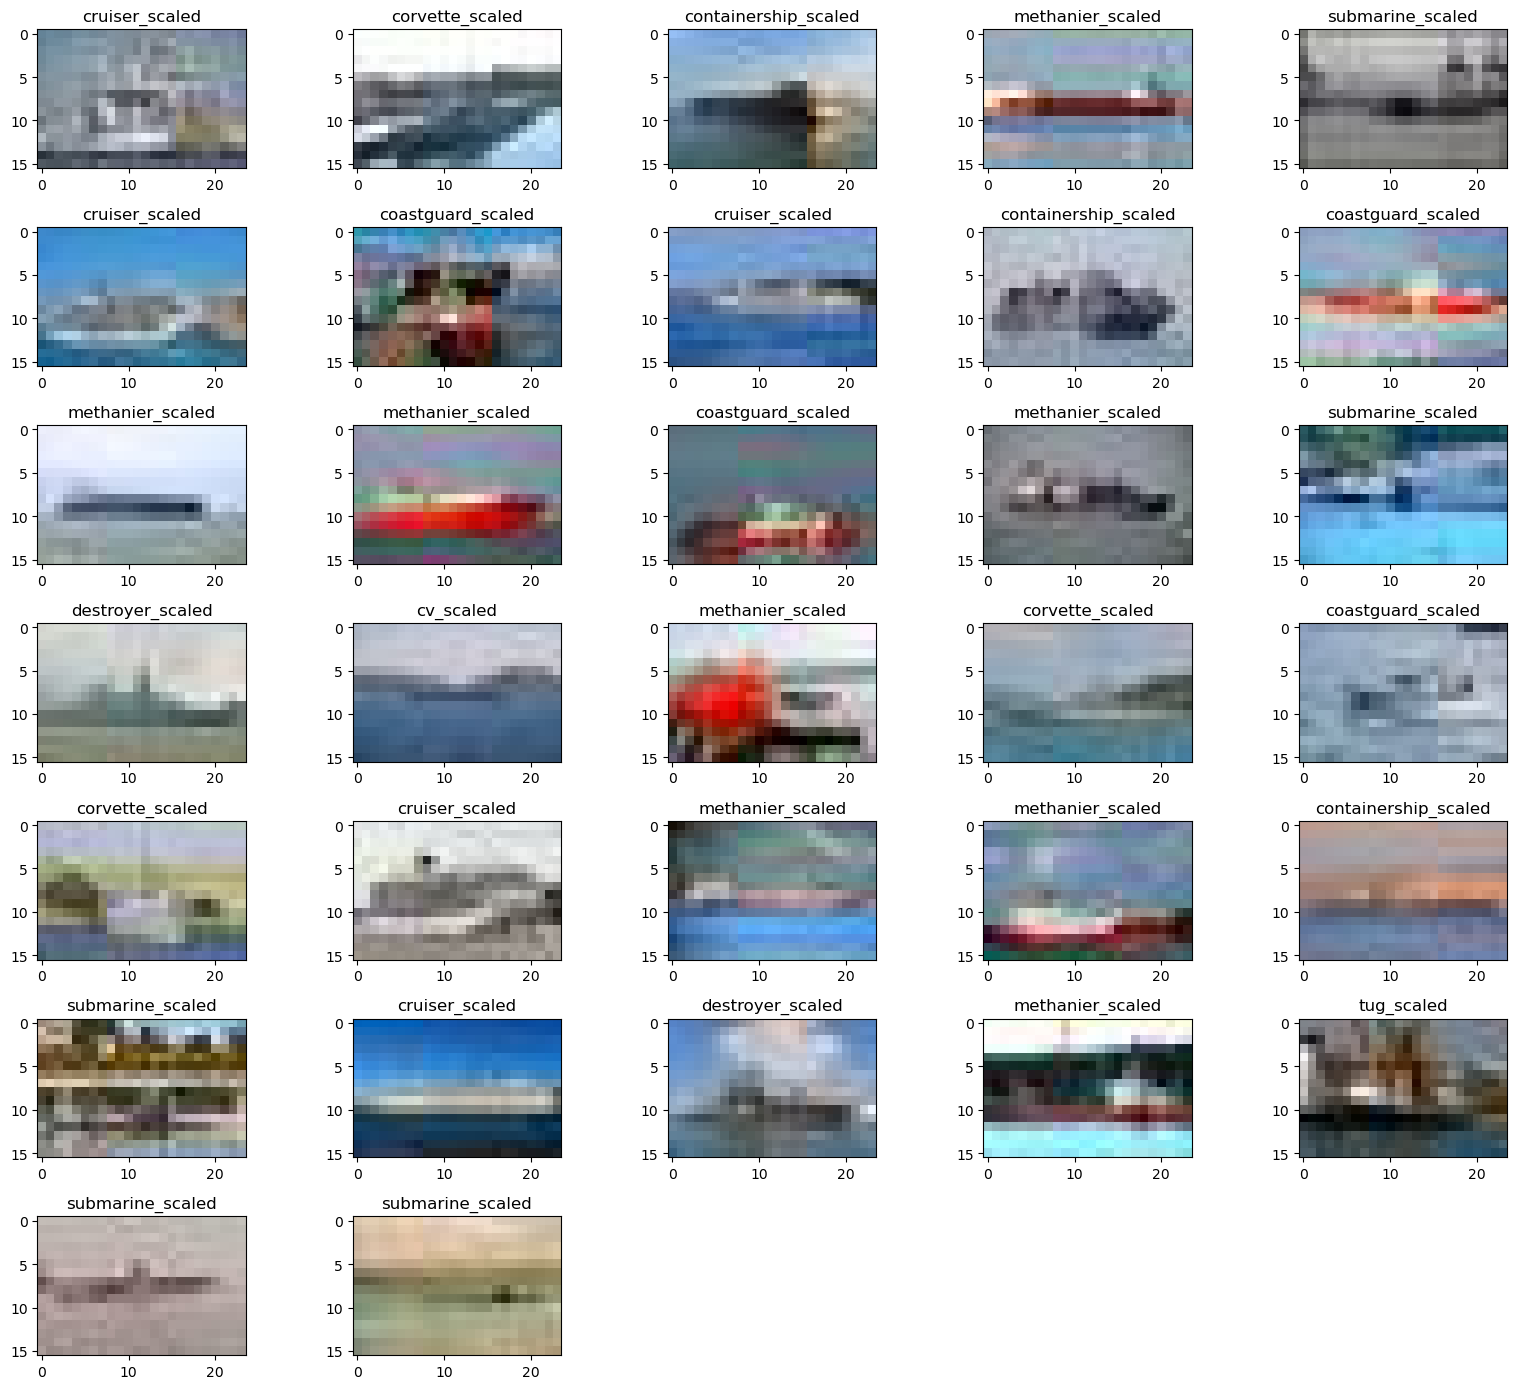

In [10]:
generator_plot(training_gen)

Batch size: 32
Image size: 16 x 24
Number of channels: 3


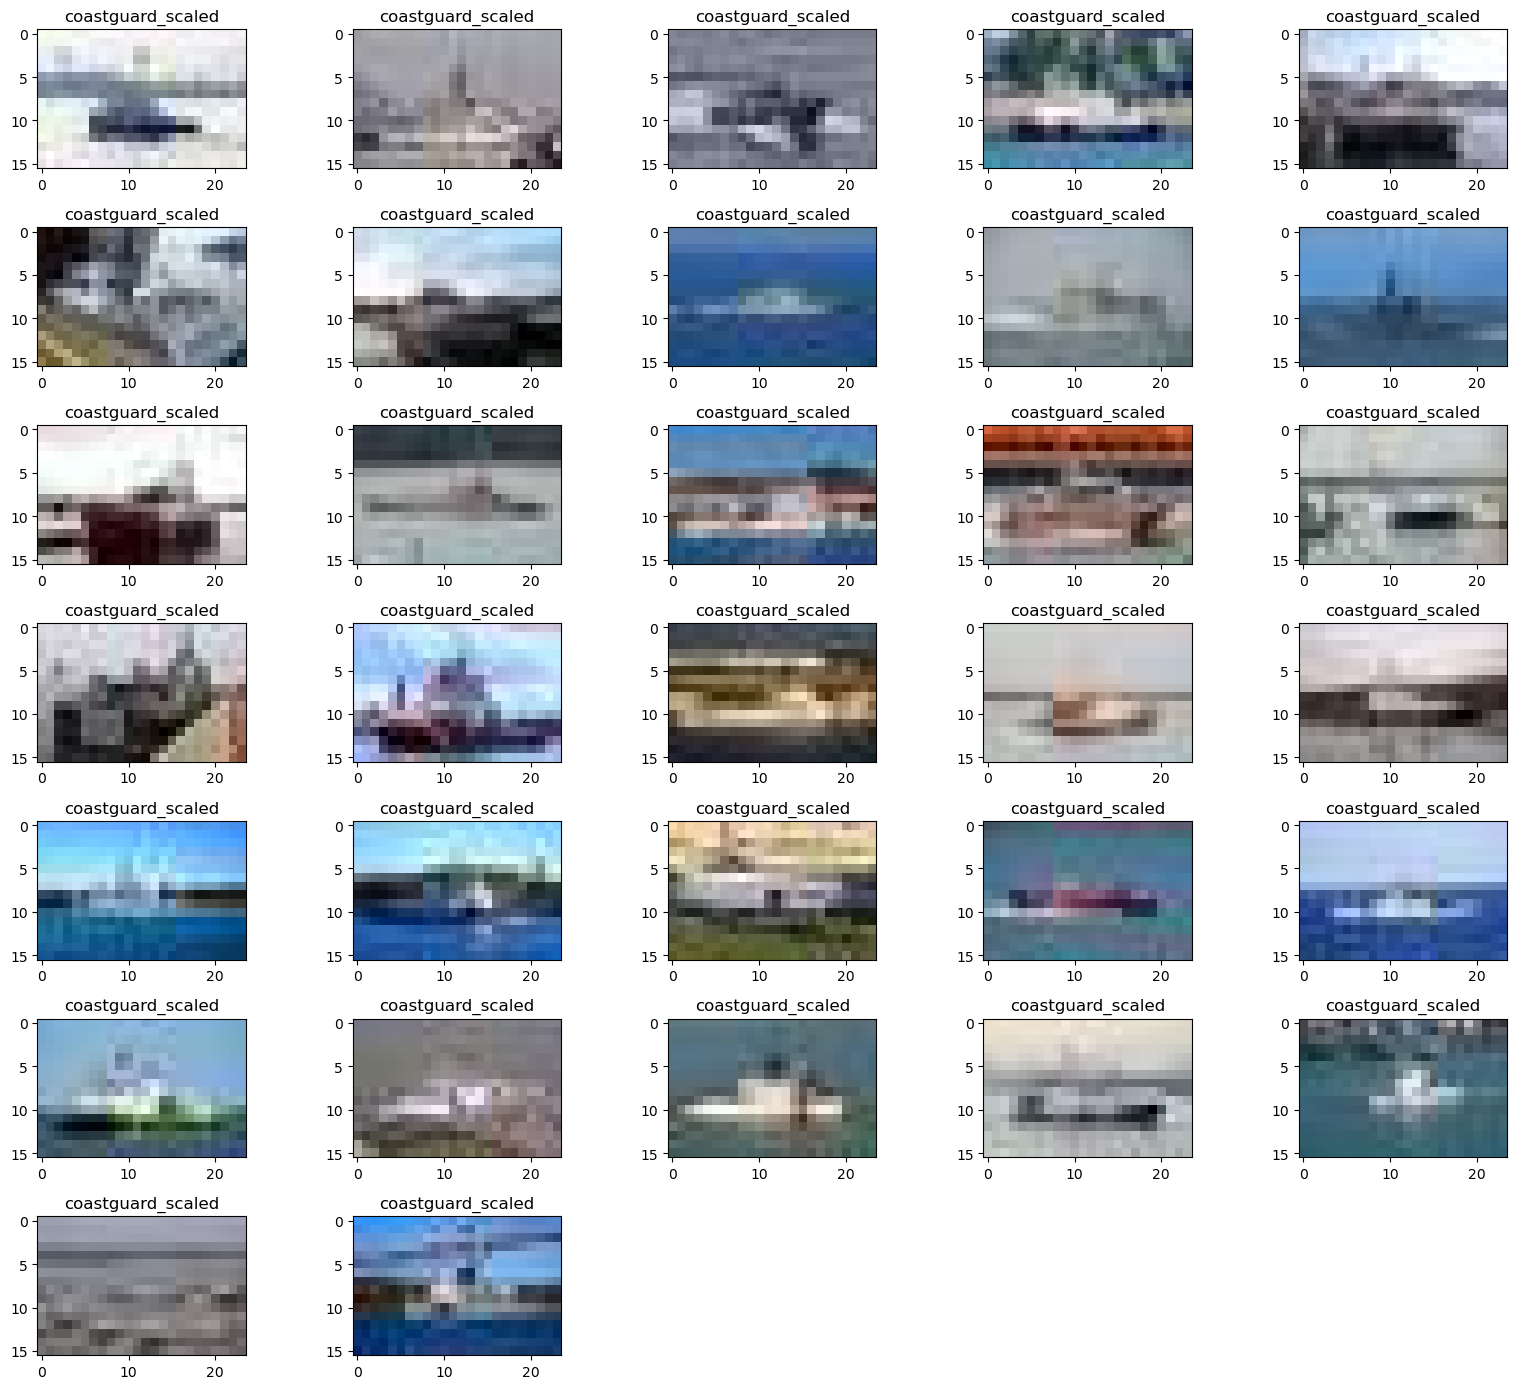

In [11]:
generator_plot(validation_gen)

## Création du réseau

Le code présent construit un modèle de classification d'images en utilisant l'architecture VGG16 comme base. L'architecture VGG16 est pré-entraînée sur le jeu de données ImageNet, ce qui permet d'exploiter les caractéristiques apprises par le modèle sur une grande variété d'images.

Le modèle commence par redimensionner les images en entrée à une taille de 48x48 pixels à l'aide de la couche Resizing, le nombre 48 a été choisi étant le PPCM(Plus Petit Commun Multiple) de 16 et 24. Ensuite, la base du modèle VGG16 est chargée en excluant la couche de classification finale (include_top=False), ce qui permet de conserver les couches convolutives et de pooling pré-apprises.

Après avoir utilisé la base du modèle VGG16, une couche de GlobalAveragePooling2D est ajoutée pour réduire les dimensions des caractéristiques extraites. Ensuite, une couche de Dropout est ajoutée pour régulariser le modèle et réduire le surapprentissage.

Enfin, trois couches Dense sont ajoutées pour effectuer la classification. La dernière couche utilise une fonction d'activation softmax pour produire des probabilités pour chaque classe.

In [12]:
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Resizing, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

init_shape=(16, 24, 3)
base_model = VGG16(input_shape=(48, 48, 3), weights='imagenet', include_top=False)

model = keras.Sequential([
    Resizing(48, 48, interpolation="bicubic", input_shape=init_shape),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.75),
    Dense(3000, activation='swish'),
    Dense(1500, activation='swish'),
    Dense(10, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.00001),
            metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 48, 48, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3000)              1539000   
                                                                 
 dense_1 (Dense)             (None, 1500)              4501500   
                                                        

In [15]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  7


Le rappel EarlyStopping est utilisé pour arrêter l'entraînement prématurément si une métrique de validation (dans ce cas, la précision) cesse de s'améliorer pendant un certain nombre d'époques défini par le paramètre "patience". Il permet d'éviter un surapprentissage excessif en stoppant l'entraînement lorsque la performance sur les données de validation ne s'améliore plus.

Le rappel ReduceLROnPlateau est utilisé pour réduire le taux d'apprentissage lorsque la perte sur les données de validation cesse de s'améliorer pendant un certain nombre d'époques défini par le paramètre "patience". Cela permet d'ajuster le processus d'apprentissage en réduisant progressivement le taux d'apprentissage afin d'atteindre une convergence plus précise.

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, verbose=2, restore_best_weights=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

Nous itèrons sur les 10 classes et calculons le poids de classe pour chaque classe en divisant le nombre d'échantillons de cette classe par le nombre total d'échantillons dans l'ensemble d'entraînement. Cela permet d'obtenir une mesure de la fréquence relative de chaque classe dans l'ensemble d'entraînement.

In [17]:
class_weights = {}
for i in range(10):
    class_weights[i] = np.sum(training_gen.classes == i) / len(training_gen.classes)

In [18]:
history = model.fit(
    training_gen,
    epochs=100,
    validation_data=validation_gen,
    batch_size=batch_size,
    max_queue_size=500,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    use_multiprocessing=True,
    workers=-1
)

Epoch 1/100
889/889 [==============================] - 119s 127ms/step - loss: 0.1658 - accuracy: 0.4086 - val_loss: 1.3312 - val_accuracy: 0.5361 - lr: 1.0000e-05
Epoch 2/100
889/889 [==============================] - 36s 41ms/step - loss: 0.1247 - accuracy: 0.5424 - val_loss: 1.1437 - val_accuracy: 0.5974 - lr: 1.0000e-05
Epoch 3/100
889/889 [==============================] - 38s 42ms/step - loss: 0.1082 - accuracy: 0.5988 - val_loss: 1.0623 - val_accuracy: 0.6282 - lr: 1.0000e-05
Epoch 4/100
889/889 [==============================] - 37s 42ms/step - loss: 0.0977 - accuracy: 0.6362 - val_loss: 0.9639 - val_accuracy: 0.6562 - lr: 1.0000e-05
Epoch 5/100
889/889 [==============================] - 38s 43ms/step - loss: 0.0888 - accuracy: 0.6640 - val_loss: 0.9434 - val_accuracy: 0.6695 - lr: 1.0000e-05
Epoch 6/100
889/889 [==============================] - 38s 43ms/step - loss: 0.0825 - accuracy: 0.6866 - val_loss: 0.9303 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 7/100
889/889 [=====

## Interprétations

In [19]:
class_list = [class_name for class_name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, class_name))]

print(class_list)

['methanier_scaled', 'corvette_scaled', 'containership_scaled', 'cruiser_scaled', 'cv_scaled', 'coastguard_scaled', 'destroyer_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']


222/222 [==============================] - 7s 32ms/step


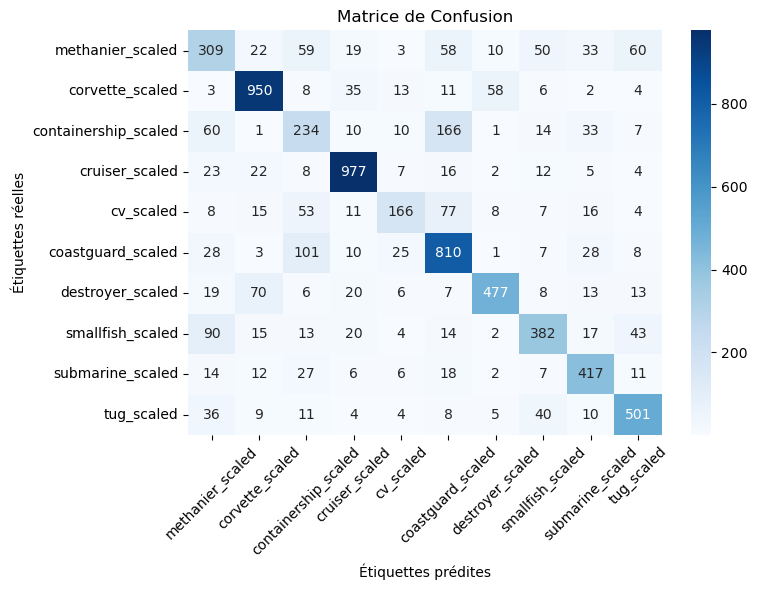

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(validation_gen)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_gen.classes, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Étiquettes prédites')
ax.set_ylabel('Étiquettes réelles')
ax.set_title('Matrice de Confusion')
ax.xaxis.set_ticklabels(class_list)
ax.yaxis.set_ticklabels(class_list)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
print('Classification Report')
print(classification_report(validation_gen.classes, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       623
           1       0.85      0.87      0.86      1090
           2       0.45      0.44      0.44       536
           3       0.88      0.91      0.89      1076
           4       0.68      0.45      0.55       365
           5       0.68      0.79      0.73      1021
           6       0.84      0.75      0.79       639
           7       0.72      0.64      0.67       600
           8       0.73      0.80      0.76       520
           9       0.76      0.80      0.78       628

    accuracy                           0.74      7098
   macro avg       0.71      0.69      0.70      7098
weighted avg       0.73      0.74      0.73      7098



Le rapport de classification fournit une évaluation détaillée des performances du modèle sur un ensemble de données de test. Dans l'ensemble, le modèle affiche une précision moyenne de 74%, ce qui signifie qu'il prédit correctement la classe des échantillons de test dans 74% des cas.

En examinant les mesures de précision, de rappel et de score F1 pour chaque classe, nous pouvons observer des variations significatives dans les performances. Certaines classes, comme la classe 3, affichent des scores élevés de précision (87%) et de rappel (91%), ce qui indique que le modèle a bien réussi à les prédire. En revanche, d'autres classes, comme la classe 2, montrent des performances inférieures avec une précision de 44% et un rappel de 47%.

La mesure F1-score est une moyenne pondérée de la précision et du rappel, qui tient compte à la fois des prédictions correctes et des faux positifs/négatifs. L'indice F1-score est généralement utilisé pour évaluer l'équilibre entre la précision et le rappel. Dans notre cas, la moyenne F1-score est de 70%, ce qui suggère une performance globale modérée du modèle.

En conclusion, le modèle présente des performances variables selon les classes, avec des résultats solides pour certaines classes et des améliorations potentielles nécessaires pour d'autres. Pour améliorer les performances, il pourrait être bénéfique d'explorer des stratégies telles que l'ajustement des poids de classe, l'augmentation des données ou l'exploration de modèles plus avancés.

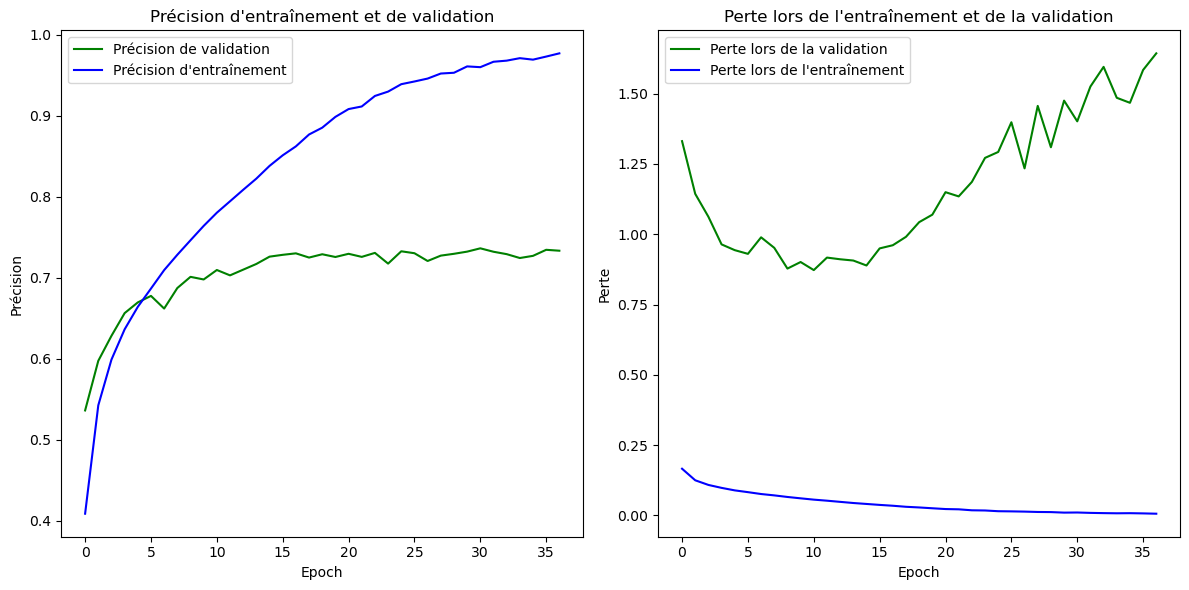

889/889 [==============================] - 29s 32ms/step - loss: 0.0699 - accuracy: 0.9786
Précision du modèle sur l'ensemble de test: 97.86%


In [22]:
def training_plot(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], 'g', label="Précision de validation")
    plt.plot(history.history['accuracy'], 'b', label="Précision d'entraînement")
    plt.title("Précision d'entraînement et de validation")
    plt.xlabel("Epoch")
    plt.ylabel("Précision")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], 'g', label="Perte lors de la validation")
    plt.plot(history.history['loss'], 'b', label="Perte lors de l'entraînement")
    plt.title("Perte lors de l'entraînement et de la validation")
    plt.xlabel("Epoch")
    plt.ylabel("Perte")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

training_plot(history)

test_score = model.evaluate(training_gen)
accuracy = test_score[1] * 100
print(f"Précision du modèle sur l'ensemble de test: {accuracy:.2f}%")

En observant les courbes, on peut en déduire plusieurs informations.

- Précision : Si la précision de validation augmente et se rapproche de la précision d'entraînement, cela indique que le modèle généralise bien et est capable de bien classer de nouvelles données. Si la précision de validation reste faible par rapport à la précision d'entraînement, cela peut indiquer un problème de surapprentissage (overfitting) du modèle.

- Perte : Si la perte d'entraînement diminue progressivement et que la perte de validation diminue également, cela suggère que le modèle apprend efficacement et parvient à généraliser correctement. Si la perte d'entraînement diminue rapidement tandis que la perte de validation augmente, cela peut indiquer un surapprentissage.

La courbe de précision montre une progression régulière de la précision du modèle, indiquant une performance satisfaisante. On observe une convergence entre la précision d'entraînement et de validation à certains moments, ce qui suggère que le modèle généralise bien. Il y a des indications claires d'overfitting à partir de l'epoch 5, ce qui n'est pas encourageant.

La courbe de perte démontre une diminution progressive des pertes d'entraînement et de validation vers des valeurs proches de zéro. Cependant, la variation de la courbe d'entraînement est faible, ce qui peut suggérer un learning rate bas ou un modèle qui underfit, aussi à partir de l'epoch 10, la courbe de perte de la validation remonte. Pour améliorer cela, il est possible d'augmenter la complexité du modèle ou d'apporter des modifications supplémentaires aux données d'entraînement pour les rendre plus complexes.

En résumé, le modèle semble avoir une performance satisfaisante avec une précision en augmentation et de moyennes pertes en diminution. Cependant, pour obtenir de meilleures performances, il peut être nécessaire d'explorer des ajustements supplémentaires.

## Résultat à soumettre

In [23]:
X_test = np.load('/kaggle/input/navires-2023-libre/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [24]:
X_test.shape, X_test.dtype

((3698, 16, 24, 3), dtype('float32'))

In [25]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

116/116 [==============================] - 1s 9ms/step


In [26]:
!head submission.csv

Id,Category
0,5
1,8
2,5
3,5
4,3
5,0
6,3
7,3
8,5


In [27]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [28]:
!rm -rf ships32/